In [19]:
import numpy as np
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt


## Question 1

Find the effect in dataset 12.1, given that Group = 1 is the treatment group and Time > 0 is the treatment time. 

In [2]:
# Load data
df = pd.read_csv('homework_12.1.csv')

In [3]:
# Create indicators for post-treatment and treatment group
df["Post"] = (df["Time"] > 0).astype(int)
df["Treatment"] = (df["Group"] == 1).astype(int)


In [4]:
# Compute means for each group/time combination
mean_treat_post = df[(df["Treatment"] == 1) & (df["Post"] == 1)]["Y"].mean()
mean_treat_pre = df[(df["Treatment"] == 1) & (df["Post"] == 0)]["Y"].mean()
mean_control_post = df[(df["Treatment"] == 0) & (df["Post"] == 1)]["Y"].mean()
mean_control_pre = df[(df["Treatment"] == 0) & (df["Post"] == 0)]["Y"].mean()

In [5]:
# Difference-in-differences estimate
effect = (mean_treat_post - mean_treat_pre) - (mean_control_post - mean_control_pre)
print("Treatment Effect (DiD):", effect)

Treatment Effect (DiD): 0.9440103783528997


## Question 2

With dataset 12.2, run a test to check prior trends. To do this, run a linear regression on the data before Time = 0, with an interaction term equal to Group x Time. Which is the closest to the t-value of the interaction term? 

In [6]:
# Load data
df = pd.read_csv('homework_12.2.csv')

In [7]:
# Keep only pre-treatment period (Time < 0)
df_pre = df[df["Time"] < 0].copy()

In [8]:
# Add interaction term Group * Time
df_pre["Group_Time"] = df_pre["Group"] * df_pre["Time"]

In [9]:
# Run regression: Y ~ Group + Time + Group*Time
model = smf.ols("Y ~ Group + Time + Group_Time", data=df_pre).fit()

# Output t-value for interaction term
t_value_interaction = model.tvalues["Group_Time"]
print("T-value for Group × Time interaction term:", t_value_interaction)

T-value for Group × Time interaction term: 5.329379663923836


## Question 3

With the following, make an error such that the correlation (np.corrcoef) between the error at time t and time t + 1 is 0.80 on average, the mean error is 0, and the standard deviation of the error is 1. (These may be approximate.) There are 10,000 items. Given: 

X = this error 

Y = 2 * X + this error (recalculated with new randomness relative to the previous line) 


The standard error of the estimated X coefficient computed via Ordinary Least Squares (OLS) basic standard error should be about 0.01. Then the standard error computed via simulation (the standard deviation of the estimated coefficient over many trials) is closest to: 

Note: you might consider Googling / asking ChatGPT how to generate an autocorrelated time series with a specific correlation and standard deviation. 

In [14]:
def make_error(n, rho):
    # AR(1) process
    e = np.zeros(n)
    e[0] = np.random.normal()
    for t in range(1, n):
        e[t] = rho * e[t-1] + np.sqrt(1 - rho**2) * np.random.normal()
    
    return e


In [13]:
np.random.seed(0)

n = 10_000
rho = 0.80
trials = 200


ols_ses = []
sim_coefs = []

for _ in range(trials):
    # Generate X's error
    err_x = make_error(n, rho)
    X = err_x

    # Generate Y's error (new randomness, independent from X's error)
    err_y = make_error(n, rho)
    Y = 2 * X + err_y

    # Run OLS
    X_ols = sm.add_constant(X)
    model = sm.OLS(Y, X_ols).fit()

    ols_ses.append(model.bse[1])
    sim_coefs.append(model.params[1])

# Basic OLS SE (mean over trials)
mean_basic_se = np.mean(ols_ses)

# Simulation SE (std dev of coefficient estimates)
sim_se = np.std(sim_coefs, ddof=1)

print("Mean OLS SE:", mean_basic_se)
print("Simulation-based SE:", sim_se)

Mean OLS SE: 0.010005821544075184
Simulation-based SE: 0.02063883057961503


## Question 4


Find the variance inflation factor of X1: 

   np.random.seed(0) 

   X1 = np.random.normal(0, 1, 1000)

   X2 = np.random.normal(0, 1, 1000) + X1 
   
   X3 = np.random.normal(0, 1, 1000) + 2 * X2 

In [15]:
np.random.seed(0)
X1 = np.random.normal(0, 1, 1000)
X2 = np.random.normal(0, 1, 1000) + X1
X3 = np.random.normal(0, 1, 1000) + 2 * X2

# Regress X1 on X2 and X3 to get R^2, then VIF = 1/(1 - R^2)
X = np.column_stack([X2, X3])
X = sm.add_constant(X)
model = sm.OLS(X1, X).fit()
R2 = model.rsquared
VIF_X1 = 1 / (1 - R2)

print("R^2 (X1 ~ X2 + X3):", R2)
print("VIF for X1:", VIF_X1)    

R^2 (X1 ~ X2 + X3): 0.4945344638582029
VIF for X1: 1.9783742480901254


## Homework Reflection 

Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong.  Explain why the
differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

In [17]:
np.random.seed(0)

# --- Parameters ---
T_pre = np.arange(-5, 0)     # pre: -5..-1
T_post = np.arange(0, 6)     # post: 0..5
times = np.concatenate([T_pre, T_post])
n_per_cell = 500             # individuals per (group, time)

beta = 0.3                   # common baseline time trend
delta = 0.20                 # EXTRA slope for treated group (violates parallel trends)
tau_true = 0.0               # TRUE treatment effect (we'll set to zero to show DiD bias)
alpha = 1.0
gamma_group = 1.0            # level difference for treated group

# --- Build panel-like dataset ---
rows = []
for g in [0, 1]:  # 0=control, 1=treated
    for t in times:
        # Treatment turns on at time >= 0 for treated group
        post = 1 if t >= 0 else 0
        treat = 1 if (g == 1 and post == 1) else 0
        
        # Generate individuals
        eps = np.random.normal(0, 1, n_per_cell)
        # Outcome model with DIFFERENTIAL trend for treated (delta), no actual treatment effect (tau_true=0)
        y = (alpha
             + beta * t
             + gamma_group * g
             + delta * t * g
             + tau_true * treat
             + eps)
        
        for i in range(n_per_cell):
            rows.append((y[i], t, g, post, treat))

df = pd.DataFrame(rows, columns=["Y", "Time", "Group", "Post", "Treat"])

When parallel trends do not hold, the differences-in-differences (DiD) estimator picks up not just the treatment effect, but also any pre-existing difference in trends between the groups. If prior trends differ (e.g., the treated group was already increasing faster), the control group no longer represents a valid counterfactual.



In [18]:
# --- Manual DiD (two-period-style using pre vs post averages) ---
mean_treat_post = df[(df.Group == 1) & (df.Post == 1)].Y.mean()
mean_treat_pre  = df[(df.Group == 1) & (df.Post == 0)].Y.mean()
mean_ctrl_post  = df[(df.Group == 0) & (df.Post == 1)].Y.mean()
mean_ctrl_pre   = df[(df.Group == 0) & (df.Post == 0)].Y.mean()
did_manual = (mean_treat_post - mean_treat_pre) - (mean_ctrl_post - mean_ctrl_pre)

# --- Regression DiD: Y ~ Group + Post + Group*Post ---
model_did = smf.ols("Y ~ C(Group) + C(Post) + C(Group):C(Post)", data=df).fit()
did_reg = model_did.params["C(Group)[T.1]:C(Post)[T.1]"]

# --- Prior-trends check on PRE period: Y ~ Group + Time + Group*Time ---
df_pre = df[df.Post == 0].copy()
model_pre = smf.ols("Y ~ C(Group) + Time + C(Group):Time", data=df_pre).fit()
t_interaction = model_pre.tvalues["C(Group)[T.1]:Time"]
coef_interaction = model_pre.params["C(Group)[T.1]:Time"]

# --- Summaries ---
summary = {
    "TRUE treatment effect (tau_true)": tau_true,
    "Manual DiD estimate": did_manual,
    "Regression DiD estimate": did_reg,
    "Pre-period differential slope (coef on Group×Time)": coef_interaction,
    "t-value for Group×Time (pre-period)": t_interaction
}
summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])

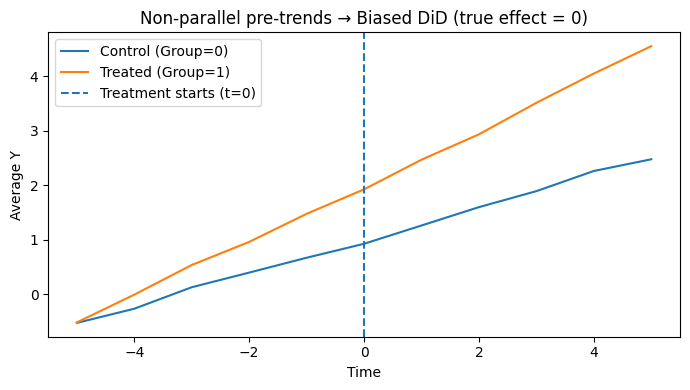

In [21]:
# --- Plot average outcomes over time by group to visualize non-parallel trends ---
avg = df.groupby(["Time", "Group"])["Y"].mean().reset_index()
pivot_avg = avg.pivot(index="Time", columns="Group", values="Y")
plt.figure(figsize=(7,4))
plt.plot(pivot_avg.index, pivot_avg[0], label="Control (Group=0)")
plt.plot(pivot_avg.index, pivot_avg[1], label="Treated (Group=1)")
plt.axvline(0, linestyle="--", label="Treatment starts (t=0)")
plt.xlabel("Time")
plt.ylabel("Average Y")
plt.title("Non-parallel pre-trends → Biased DiD (true effect = 0)")
plt.legend()
plt.tight_layout()
plt.show()